This notebooks serves as an analysis for the Z1/Z2 Circuits OED wrapper.

In [1]:
import sys
import os
import pickle
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
from scipy.signal import find_peaks
from scipy.integrate import odeint

# Add miner folder to path to load custom modules
sys.path.append(os.path.abspath("../circuits_miner"))

from get_system_equations_pop import system_equations_DsRed_pop
from define_circuit import Topo

print("Libraries loaded.")

Libraries loaded.


Loading results from: ../circuits_miner/results\Miner_Z1Z2_DsRed_2026-02-11
Found 2 Unique Topologies on Pareto Front.

Selected Circuit (Rank 0):
Topology: [('P1', 'Z1'), ('P1', 'I2'), ('Z1', 'Rep'), ('Z1', 'I2'), ('Z1', 'Z1'), ('I2', 'Z1'), ('I2', 'Rep')]
Nominal Doses: {'Rep': 200, 'I2': 45, 'Z1': 75}
Miner Prominence: 2.04


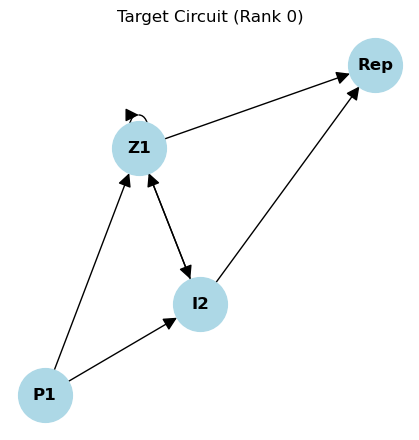

In [2]:

# 1. LOAD Z1/Z2 MINER RESULTS

# Go up one level (..), then into circuits_miner/results
MINER_RESULTS_ROOT = "../circuits_miner/results" 

# Check if path exists
if not os.path.exists(MINER_RESULTS_ROOT):
    raise FileNotFoundError(f"Could not find path: {os.path.abspath(MINER_RESULTS_ROOT)}")

# Find all run folders
all_subdirs = [
    os.path.join(MINER_RESULTS_ROOT, d) 
    for d in os.listdir(MINER_RESULTS_ROOT) 
    if os.path.isdir(os.path.join(MINER_RESULTS_ROOT, d))
]

# Filter for the Z1/Z2 runs specifically (ignore FreeSearch for now)
z1z2_runs = [d for d in all_subdirs if "Z1Z2" in d]

if not z1z2_runs:
    raise FileNotFoundError("No Z1/Z2 results found! Did you run the Z1/Z2 Miner?")

# Pick the latest one
latest_subdir = max(z1z2_runs, key=os.path.getmtime)
print(f"Loading results from: {latest_subdir}")

# Load Data
winner_pop = pd.read_pickle(f"{latest_subdir}/final_population.pkl")
winner_df = pd.read_pickle(f"{latest_subdir}/final_objectives_df.pkl")

# Fix signs (Minimization -> Maximization)
winner_df['prominence_rel'] = -winner_df['prominence_rel']
winner_df['circuit_object'] = [ind[0] for ind in winner_pop]

# Group by Unique Topology
winner_df['topology_sig'] = winner_df['circuit_object'].apply(lambda c: tuple(sorted(c.edge_list)))
unique_topos = winner_df[winner_df['prominence_rel'] > 0.1].sort_values('prominence_rel', ascending=False).groupby('topology_sig').first().reset_index()

print(f"Found {len(unique_topos)} Unique Topologies on Pareto Front.")


# 2. SELECT TARGET

# Rank 0 = The "Best" (highest prominence)
# Rank 1 = The "Runner up" (second best interms of prominence)
TARGET_RANK = 0

if TARGET_RANK >= len(unique_topos):
    print(f"Error: Rank {TARGET_RANK} out of bounds. Defaulting to 0.")
    TARGET_RANK = 0

target_row = unique_topos.iloc[TARGET_RANK]
target_circuit = target_row['circuit_object']
nominal_prom = target_row['prominence_rel']

print(f"\nSelected Circuit (Rank {TARGET_RANK}):")
print(f"Topology: {target_circuit.edge_list}")
print(f"Nominal Doses: {target_circuit.dose}")
print(f"Miner Prominence: {nominal_prom:.2f}")

# Visualize Topology
G = nx.DiGraph(target_circuit.edge_list)
pos = nx.spring_layout(G, seed=25)
plt.figure(figsize=(4, 4))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1500, font_weight='bold', arrowsize=20)
plt.title(f"Target Circuit (Rank {TARGET_RANK})")
plt.show()

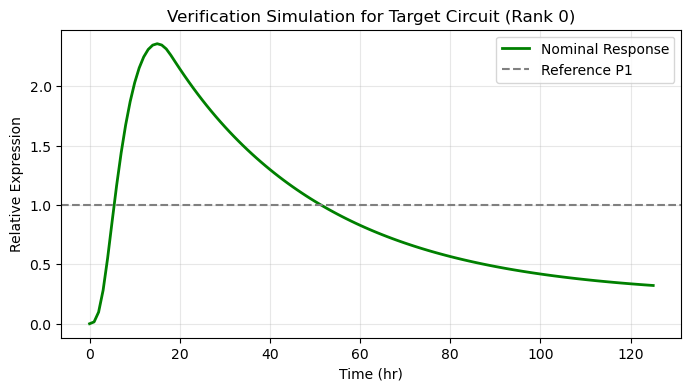

Verification Max Prominence: 2.04
SUCCESS: Circuit pulses. Proceeding to OED.


In [3]:

# VERIFICATION SIMULATION

# Load Nominal Parameters
PARTS_PATH = "../circuits_miner"

with open(f"{PARTS_PATH}/promo.pkl", "rb") as f: nominal_promo = pickle.load(f)
with open(f"{PARTS_PATH}/parts.pkl", "rb") as f: nominal_parts = pickle.load(f)
with open(f"{PARTS_PATH}/Ref.pkl", "rb") as f:   Ref_data = pickle.load(f)

# Simulation Config
t_span = np.arange(0, 126, 1)
ref_val = Ref_data[target_circuit.promo_node]['on']

# RUN SIMULATION (Using DsRed Physics)
y_nominal = odeint(
    system_equations_DsRed_pop,
    np.zeros(target_circuit.num_states * 2),
    t_span,
    args=('on', np.ones(5), target_circuit, nominal_promo, nominal_parts)
)[:, -1]

y_rel = y_nominal / (ref_val + 1e-9)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(t_span, y_rel, 'g-', linewidth=2, label='Nominal Response')
plt.xlabel("Time (hr)")
plt.ylabel("Relative Expression")
plt.title(f"Verification Simulation for Target Circuit (Rank {TARGET_RANK})")
plt.axhline(1.0, linestyle='--', color='gray', label='Reference P1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Check Peak
prom_val = np.max(y_rel) - y_rel[-1]
print(f"Verification Max Prominence: {prom_val:.2f}")
if prom_val < 1.5:
    print("WARNING: Pulse is very weak. Check dosage or settings.")
else:
    print("SUCCESS: Circuit pulses. Proceeding to OED.")

In [ ]:
# 1. EXPERIMENTAL CONFIGURATION

# File to save/load simulation data
DATA_FILE = "oed_z1z2_simulation_data.pkl"

# Simulation Parameters
N_SAMPLES = 200           # 200 Virtual Cells
PERTURBATION_SCALE = 0.2  # k=0.2 (10^0.2 ~= 1.6x variation).
SIM_TIME = 126            # Hours

# Dosage Grid
# 0.2x to 4.0x in 20 steps covers the "Starved" to "Saturated" regime
DOSAGE_SCALERS = np.linspace(0.2, 4.0, 20) # stepsize = 0.2

print("Configuration Loaded.")
print(f"Noise Scale: {PERTURBATION_SCALE} (approx +/- 60%)")
print(f"Dosage Grid: {len(DOSAGE_SCALERS)} points from {DOSAGE_SCALERS[0]:.1f}x to {DOSAGE_SCALERS[-1]:.1f}x")

Configuration Loaded.
Noise Scale: 0.2 (approx +/- 60%)
Dosage Grid: 20 points from 0.2x to 4.0x


In [7]:

# 2. DATA GENERATION 

def run_simulation_campaign():
    
    # A. Load Nominal Miner Result (The "Seed")
    miner_results_path = "../circuits_miner/results"
    
    # Filter for valid Z1Z2 directories
    all_subdirs = [
        os.path.join(miner_results_path, d) 
        for d in os.listdir(miner_results_path) 
        if "Z1Z2" in d and os.path.isdir(os.path.join(miner_results_path, d))
    ]
    
    if not all_subdirs:
        raise FileNotFoundError("No Z1/Z2 results found in ../circuits_miner/results")
        
    latest_subdir = max(all_subdirs, key=os.path.getmtime)
    
    try:
        with open(f"{latest_subdir}/final_population.pkl", "rb") as f:
            final_pop = pickle.load(f)
        with open(f"{latest_subdir}/final_objectives_df.pkl", "rb") as f:
            final_df = pd.read_pickle(f)
    except Exception as e:
        print(f"Error loading miner results: {e}")
        raise

    # Load Parts & Physics
    miner_path = "../circuits_miner"
    with open(f"{miner_path}/parts.pkl", "rb") as f: parts = pickle.load(f)
    with open(f"{miner_path}/promo.pkl", "rb") as f: promo = pickle.load(f)
    with open(f"{miner_path}/Ref.pkl", "rb") as f:   ref = pickle.load(f)

    # Identify Winner
    best_idx = final_df['prominence_rel'].idxmin() 
    winner_circuit = final_pop[best_idx][0]
    ref_val = ref[winner_circuit.promo_node]['on']
    
    print(f"   Loaded Winner from: {latest_subdir}")
    print(f"   Reference Value: {ref_val:.2f}")

    # B. Generate Virtual Population (200 Cells)
    # Sample #0 is Nominal.
    pop_parts = [parts] 
    
    # Every cell gets the EXACT same P1 promoter settings.
    # We create a list of 200 identical copies.
    pop_promo = [promo] * N_SAMPLES 
    
    print("   Generating 200 Virtual Mutants (Internal Parts Only)...")
    
    for _ in range(N_SAMPLES - 1):
        # Perturb ONLY the Parts (Z1, Z2, Rep parameters)
        p_mut = {}
        for k, v in parts.items():
            if isinstance(v, dict):
                # Handle nested dict (e.g. {'Z1': {'Kd': 10...}})
                p_mut[k] = {sk: sv * (10 ** np.random.uniform(-PERTURBATION_SCALE, PERTURBATION_SCALE)) for sk, sv in v.items()}
            else:
                # Handle scalar
                p_mut[k] = v * (10 ** np.random.uniform(-PERTURBATION_SCALE, PERTURBATION_SCALE))
        pop_parts.append(p_mut)

    # C. Run Dosage Scan
    campaign_data = {}
    t_span = np.arange(0, SIM_TIME, 1)
    
    print(f"   Simulating {N_SAMPLES} cells across {len(DOSAGE_SCALERS)} dosages...")
    
    for d_scale in tqdm(DOSAGE_SCALERS):
        # Scale Doses
        scaled_dose = {k: v * d_scale for k, v in winner_circuit.dose.items() if k != 'Rep'}
        scaled_dose['Rep'] = winner_circuit.dose['Rep']
        
        # Re-initialize circuit with new dosage
        temp_circuit = Topo(winner_circuit.edge_list, scaled_dose, winner_circuit.promo_node)
        
        traces = np.zeros((N_SAMPLES, len(t_span)))
        
        for i in range(N_SAMPLES):
            # Integrate ODE
            y = odeint(
                system_equations_DsRed_pop,
                np.zeros(temp_circuit.num_states * 2),
                t_span,
                args=('on', np.ones(5), temp_circuit, pop_promo[i], pop_parts[i])
            )[:, -1]
            
            traces[i, :] = y / (ref_val + 1e-9)
            
        campaign_data[d_scale] = traces

    # D. Save to Disk
    with open(DATA_FILE, "wb") as f:
        pickle.dump(campaign_data, f)
    print(f">> Data saved to {DATA_FILE}")
    return campaign_data

# CHECK AND LOAD
if os.path.exists(DATA_FILE):
    print(f">> Found existing data: {DATA_FILE}. Loading...")
    with open(DATA_FILE, "rb") as f:
        campaign_data = pickle.load(f)
else:
    campaign_data = run_simulation_campaign()

print("Simulation Complete.")

>> Found existing data: oed_z1z2_simulation_data.pkl. Loading...
Simulation Complete.


In [5]:

# 3. METRIC DEFINITIONS

def get_pulse_metrics(trace):
    """
    Returns (Prominence, Time_to_Peak, Quality_Score)
    Quality_Score = 1.0 if good pulse, 0.0 if saturated/flat
    """
    peak_idx = np.argmax(trace)
    peak_val = trace[peak_idx]
    final_val = trace[-1]
    
    # 1. Filter: Saturation
    # Threshold: 20% drop --> Can change this based on how strict we want to be.
    # If the signal doesn't drop by at least 20% after peak, it's a step, not a pulse.
    relative_drop = (peak_val - final_val) / (peak_val + 1e-9)
    if relative_drop < 0.2: 
        return 0.0, 0.0, 0.0 # Bad pulse
    
    # 2. Filter: Boundary Peaks
    if peak_idx == 0 or peak_idx == len(trace)-1:
        return 0.0, 0.0, 0.0 # Bad pulse
        
    prominence = peak_val - final_val
    time_to_peak = peak_idx # In hours (since dt=1)
    
    return prominence, time_to_peak, 1.0 # Good pulse

def analyze_dosage(traces):
    """
    Computes variance metrics for a single dosage ensemble.
    """
    proms = []
    times = []
    valid_count = 0
    
    for trace in traces:
        p, t, q = get_pulse_metrics(trace)
        if q > 0.5: # Valid
            proms.append(p)
            times.append(t)
            valid_count += 1
            
    # If too few valid pulses (<10%), this dosage is useless (e.g. too low or too saturated)
    if valid_count < (len(traces) * 0.1):
        return 0.0, 0.0, valid_count
    
    # Calculate Variances of VALID pulses only
    # Normalize by mean to get Coefficient of Variation (CV) like metric? 
    # Or just raw variance? Let's use Variance for now.
    var_prom = np.var(proms)
    var_time = np.var(times)
    
    return var_prom, var_time, valid_count

In [8]:

# 4. RUN ANALYSIS

param_variances = []
time_variances = []
valid_counts = []
dosages = sorted(campaign_data.keys())

for d in dosages:
    traces = campaign_data[d]
    vp, vt, vc = analyze_dosage(traces)
    param_variances.append(vp)
    time_variances.append(vt)
    valid_counts.append(vc)

# Normalize metrics for combination
# (Map 0-1 so we can sum them)
norm_vp = np.array(param_variances) / (np.max(param_variances) + 1e-9)
norm_vt = np.array(time_variances) / (np.max(time_variances) + 1e-9)

# Combined Metric (Weighted Average)
# 70% Prominence (Shape), 30% Timing
combined_score = 0.7 * norm_vp + 0.3 * norm_vt

# Identify Key Dosages
idx_max = np.argmax(combined_score)
idx_min = np.argmin(combined_score[:15]) # Min in the lower/mid range (ignore ultra-high saturation)
idx_base = np.abs(np.array(dosages) - 1.0).argmin() # Closest to 1.0x

print(f"Optimal Dosage: {dosages[idx_max]:.2f}x (Score: {combined_score[idx_max]:.2f})")
print(f"Max Prom Variance at: {dosages[np.argmax(param_variances)]:.2f}x")
print(f"Max Time Variance at: {dosages[np.argmax(time_variances)]:.2f}x")

Optimal Dosage: 4.00x (Score: 0.79)
Max Prom Variance at: 1.00x
Max Time Variance at: 0.40x


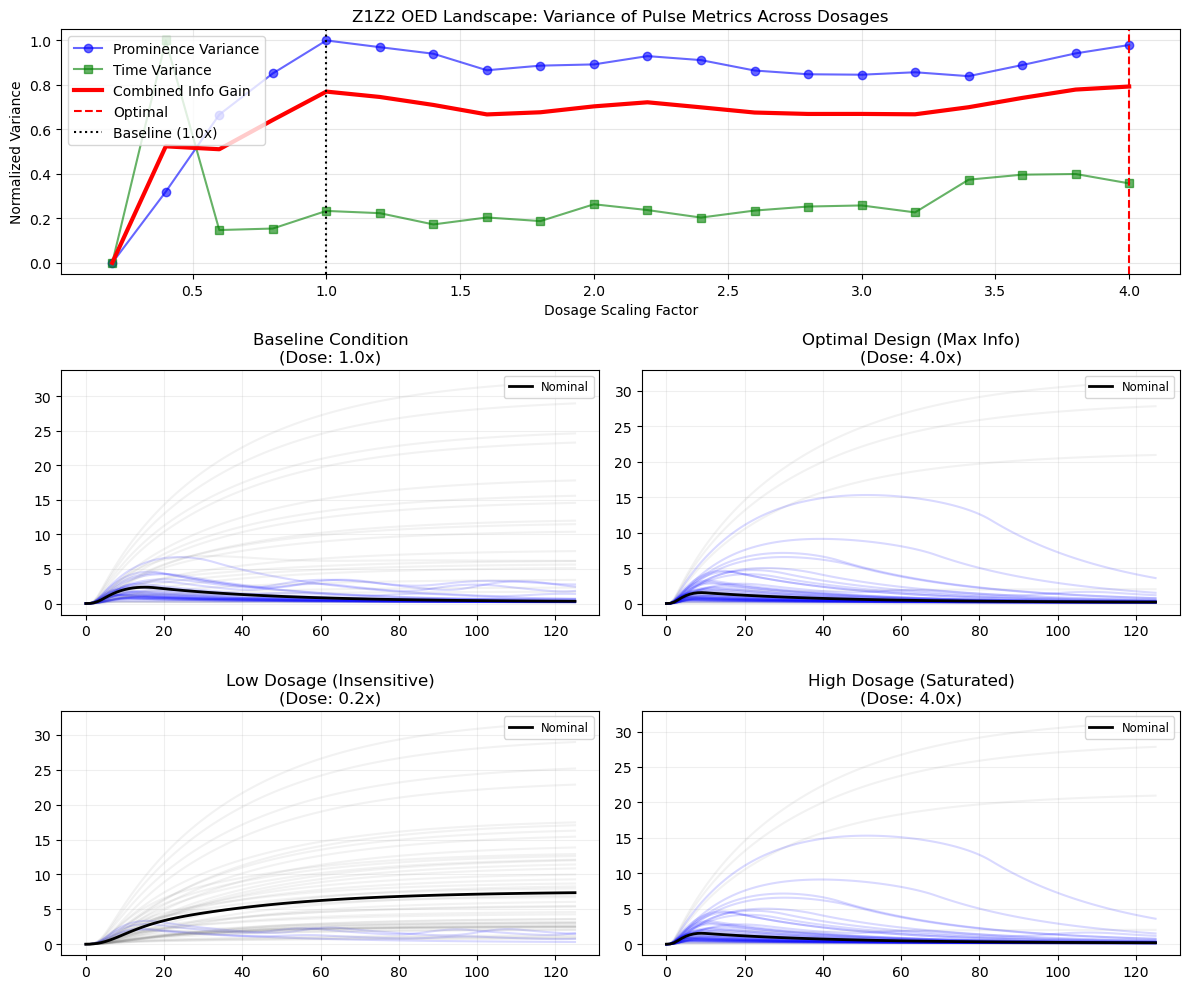

In [9]:

# 5. VISUALIZATION

fig = plt.figure(figsize=(12, 10))

# --- PLOT 1: METRICS LANDSCAPE ---
ax0 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
ax0.plot(dosages, norm_vp, 'b-o', label='Prominence Variance', alpha=0.6)
ax0.plot(dosages, norm_vt, 'g-s', label='Time Variance', alpha=0.6)
ax0.plot(dosages, combined_score, 'r-', linewidth=3, label='Combined Info Gain')

# Mark Key Points
ax0.axvline(dosages[idx_max], color='r', linestyle='--', label='Optimal')
ax0.axvline(1.0, color='k', linestyle=':', label='Baseline (1.0x)')

ax0.set_title("Z1Z2 OED Landscape: Variance of Pulse Metrics Across Dosages")
ax0.set_ylabel("Normalized Variance")
ax0.set_xlabel("Dosage Scaling Factor")
ax0.legend()
ax0.grid(True, alpha=0.3)

# --- PLOT 2: SPAGHETTI SUBPLOTS (2x2 Grid) ---
# Helper to plot ensemble
def plot_ensemble(ax, dose_idx, title):
    d = dosages[dose_idx]
    traces = campaign_data[d]
    t_span = np.arange(0, 126, 1)
    
    # Plot first 50 traces (Thin lines)
    for i in range(50):
        # Color based on validity?
        p, t, q = get_pulse_metrics(traces[i])
        color = 'blue' if q > 0.5 else 'gray'
        alpha = 0.15 if q > 0.5 else 0.1
        ax.plot(t_span, traces[i], color=color, alpha=alpha)
        
    # Plot Nominal (Index 0 - Thick Black)
    ax.plot(t_span, traces[0], 'k-', linewidth=2, label='Nominal')
    
    # Stats
    ax.set_title(f"{title}\n(Dose: {d:.1f}x)")
    ax.legend(loc='upper right', fontsize='small')
    ax.grid(True, alpha=0.2)

# Subplot 1: Baseline (1.0x)
ax1 = plt.subplot2grid((3, 2), (1, 0))
plot_ensemble(ax1, idx_base, "Baseline Condition")

# Subplot 2: Optimal (Max Variance)
ax2 = plt.subplot2grid((3, 2), (1, 1))
plot_ensemble(ax2, idx_max, "Optimal Design (Max Info)")

# Subplot 3: Low/Min Variance (Dead zone)
ax3 = plt.subplot2grid((3, 2), (2, 0))
plot_ensemble(ax3, 0, "Low Dosage (Insensitive)")

# Subplot 4: Saturated (High Dose)
ax4 = plt.subplot2grid((3, 2), (2, 1))
plot_ensemble(ax4, -1, "High Dosage (Saturated)")

plt.tight_layout()
plt.show()